# **아파트 실거래가 예측 프로젝트**


## **Stage 5. 모델링의 활용 - <font color="blue">HOW</font> 어떻게 아파트 가격을 예측할까?**
<img src='http://drive.google.com/uc?export=view&id=1YxAfXpNVAc4KVtFdjNhtY5LzTpE5VBx8' /><br>


## **INTRO**
지난 스테이지 **Stage 4.  EDA 기반 시각화 및 가공 - <font color="blue">WHERE</font>  어디서 아파트 가격이 잘 나타날까?** 에서 변수별 특징을 파악하고, 다양한 전처리와 모델링 기법을 적용해보았습니다 😀     

실거래가 데이터는 **'거래일자'**에 관한 시계열 변수가 포함되어 있는데요,     
이처럼 시계열 변수가 포함된 경우 **시계열 관점에서 데이터를 분석**할 수 있습니다 😎    

이번 스테이지는 한 번쯤 다뤄보면 유용한 시계열 분석에 대해 설명하고, 시계열 관점에서의 인사이트를 도출할 예정입니다. 

프로젝트의 아파트 실거래가 예측에 집중하고 싶으시거나 스테이지 완료 후 천천히 확인하고 싶으시다면,     
**3. 최적 모델 선택 및 비교** 파트로 넘어가셔도 좋습니다~

먼저, 한글 폰트를 설정하기 위한 약간의 준비를 하겠습니다!
한글 폰트를 다운로드하고, 적용하는 코드입니다.

In [ ]:
# 폰트 설정
# 1. 한글 폰트 다운로드 및 환경 구성
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

In [ ]:
import matplotlib.pyplot as plt

# 2. 나눔바른고딕 한글 폰트로 적용
plt.rc('font', family='NanumBarunGothic')

이전에 외부데이터와 결합한 데이터를 불러와봅시다. 많이 진행하셔서 이제 익숙하실 것이라 생각해요! 😉

In [ ]:
# 외부데이터 결합한 데이터
train = pd.read_csv('/content/drive/MyDrive/데이크루4기_먼스크루/data/data+other/train_with_other_data.csv')
test = pd.read_csv('/content/drive/MyDrive/데이크루4기_먼스크루/data/data+other/test_with_other_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


사용하지 않는 컬럼을 삭제해줍니다.

In [ ]:
drop_col = ['dong', '시군구명']
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

### **1. 시계열 기반 머신러닝/딥러닝 소개**
시계열 분석에 앞서, 시계열 분석이 무엇인지 알아야겠죠?    

**시계열 분석**은 **어떤 현상에 대하여 과거에서부터 현재까지의 시간에 흐름에 따라 기록된 데이터를 바탕으로 미래의 변화에 대한 추세를 분석하는 방법**을 말해요.

🤔 개념만으로는 이해하기 어렵네요.. 간단한 사례를 확인해볼까요?
```
철수는 2월 21일에 외출을 해야하는데 비가 내릴지 예측하고 싶어요. 🌧
과거에 비가 내린 날을 살펴보니 1년 전 같은 날짜에 비가 왔었네요. 
철수는 비가 올 것으로 예측하고, 우산을 들고 갑니다. ☂
```
여기서 **과거의 비가 내린 날로 미래의 비가 내릴지 분석한 것**을 시계열 분석이라고 해요. 

분석을 위해 과거 비에 대한 변수 한 개만 사용하면, **일변량 시계열(Univaritate Time Series) 분석석**이라고 해요.    
기온, 습도 등 여러 변수를 사용하면, **다변량 시계열(Multivariate Time Series) 분석**이라고 한답니다. 다변량 시계열 분석에서는 여러 변수들 사이의 의존성도 고려해야해요!





##### **Inst.**
먼저, 시계열 데이터를 만들어봅시다.    

거래일자에 따라 평균을 구할 컬럼을 고릅니다. 여기서는 전체 컬럼을 선택했어요!    

판다스의 groupby() 함수로 거래일자에 대해 각 컬럼의 평균을 구해서 확인해봅시다.

1. train 데이터프레임의 모든 컬럼을 feature_col 변수에 저장해요.
2. 거래일자(transaction_ymd) 컬럼 제외: 거래일자(transaction_ymd)는 groupby 기준 컬럼이므로 feature_col에서 제외하고요, 
3. groupby & mean: train 데이터프레임을 거래일자(transaction_ymd) 기준으로 groupby하여 feature_col에 저장된 컬럼들의 평균값을 구해요.
4. reset_index()로 groupby된 데이터프레임의 인덱스를 다시 설정합니다.
5. head()로 새로운 데이터프레임의 첫 5행을 출력해볼까요?

##### **Hint.**
Pandas의 groupby() 함수는 데이터를 그룹화하여 그룹별로 집계, 변환, 필터링 등의 작업을 수행할 수 있도록 해주는 함수입니다.     
아래는 groupby() 함수의 주요 파라미터와 기능입니다~

- by: 그룹화할 열의 이름, 열의 리스트, 딕셔너리 등을 지정합니다.
- level: MultiIndex 데이터프레임인 경우, 그룹화할 레벨을 지정합니다.
- as_index: 그룹화한 열을 인덱스로 사용할지 여부를 지정합니다. 기본값은 True로, 인덱스로 사용합니다.
- sort: 그룹화한 결과를 정렬할지 여부를 지정합니다. 기본값은 True로, 정렬합니다.
- group_keys: 그룹화한 결과를 그룹 키로 사용할지 여부를 지정합니다. 기본값은 True로, 그룹 키를 사용합니다.
- squeeze: 그룹화한 결과가 하나의 열만을 가지는 경우, Series로 변환할지 여부를 지정합니다. 기본값은 False로, DataFrame으로 반환합니다.

groupby() 함수는 이외에도 agg(), filter(), transform() 등 다양한 메서드를 함께 사용하여 그룹화한 결과를 집계, 필터링, 변환을 사용할 수 있어요!    
여기서는 평균을 구하는 mean()를 사용하면 좋겠죠?

##### **Solution**
아래 코드는 거래일자별로 각 변수들의 평균값을 구하여, 새로운 데이터프레임으로 반환하는 코드입니다.

In [ ]:
feature_col = train.columns # 거래일자별로 평균을 구할 컬럼을 추출
feature_col = feature_col.drop(['transaction_ymd']) # 거래일자(transaction_ymd)는 group by 기준 컬럼이므로 제외

time_train = train.groupby('transaction_ymd')[feature_col].mean().reset_index()
time_train.head()

,transaction_ymd,exclusive_use_area,floor,transaction_real_price,인구밀도,기준금리,정당_우,정당_좌,정당_기타,jeonse,num_station,num_school,num_alumni,park_number,center_number,life_of_apartment
0,20080105,71.327958,8.538795,35853.846989,18535.429192,5.0,5.888768,9.465003,10.151384,53.704319,10.448182,0.957678,423.636462,57.284862,302.640260,11.307651
1,20080115,71.180564,8.433262,35229.293326,18650.262648,5.0,5.792250,9.231970,9.911733,53.986401,10.185684,0.942411,423.603875,51.562971,286.076426,11.674919
2,20080126,71.533814,8.317531,34880.796512,18673.910107,5.0,5.852415,9.328265,9.958855,53.977647,10.119410,0.957513,430.889088,54.633721,293.400268,11.632379
3,20080205,72.199517,8.406412,35808.044194,18655.615251,5.0,5.904679,9.361352,9.974003,54.202969,10.240035,0.992201,450.195841,56.129983,293.586655,11.467071
4,20080215,70.831243,8.342310,34401.071580,18695.186747,5.0,5.874911,9.369596,9.986889,54.114574,10.135719,0.947201,421.894755,51.796953,302.695252,11.652020


거래일자별로 값이 잘 구성되어 있네요!

##### **Inst.**
시계열 데이터로 시각화하고 분석하기 위해 거래일자 컬럼을 인덱스로 만들어봅시다 😀    
주요 함수로 변환 절차를 확인해볼까요?    
1. pd.to_datetime(): time_train 데이터프레임에서 astype('str')로  'transaction_ymd' 컬럼을 문자열 형태로 변환하고,    
이를 datetime 형식으로 변경해요.
2. sort_values(): 'transaction_ymd' 컬럼을 기준으로 time_train 데이터프레임을 오름차순으로 정렬할게요.
3. set_index(): 정렬된 time_train 데이터프레임에서 'transaction_ymd' 컬럼을 인덱스로 설정해줘요.
4. head(): 인덱스가 설정된 데이터프레임의 첫 5행을 출력해볼까요?

##### **Hint.**
함수의 파라미터와 반환값을 중심으로 pd.to_datetime()과 sort_values()를  확인해봐요 😀
- pd.to_datetime()
    - 파라미터
        - arg: 날짜 형식으로 변환할 객체(str, list, tuple, ndarray, Series, DataFrame 등)
        - format: 날짜 형식 지정 (옵션)
        - errors: 변환 중 에러 처리 방법 지정 (raise, coerce, ignore 중 선택 가능)
    - 반환값: datetime 형식으로 변환된 객체 반환

- sort_values()
    - 파라미터
        - by: 정렬 기준이 되는 컬럼(혹은 컬럼의 리스트)
        - axis: 정렬할 축(0: 행, 1: 열)
        - ascending: 오름차순 정렬 여부 (True: 오름차순, False: 내림차순)
        - inplace: 원본 데이터프레임에 정렬 결과를 반영할지 여부 (True면 결과를 반영하고, False면 새로운 데이터프레임 반환)
    - 반환값: 정렬된 새로운 데이터프레임 반환

##### **Solution**
거래일자를 datetime 형식으로 변환하고,     
날짜별로 정렬하여 인덱스를 설정함으로써,     
시간에 따른 변수들의 변화를 파악하기 쉽게 만들어줬네요!

In [ ]:
# datetime 형식으로 변환
time_train['transaction_ymd'] = pd.to_datetime(time_train['transaction_ymd'].astype('str'))

# 거래일자 순서로 데이터 정렬
time_train = time_train.sort_values(by=['transaction_ymd'])

# 거래일자을 인덱스로 설정
time_train = time_train.set_index('transaction_ymd')

time_train.head()

,exclusive_use_area,floor,transaction_real_price,인구밀도,기준금리,정당_우,정당_좌,정당_기타,jeonse,num_station,num_school,num_alumni,park_number,center_number,life_of_apartment
transaction_ymd,,,,,,,,,,,,,,,
2008-01-05,71.327958,8.538795,35853.846989,18535.429192,5.0,5.888768,9.465003,10.151384,53.704319,10.448182,0.957678,423.636462,57.284862,302.640260,11.307651
2008-01-15,71.180564,8.433262,35229.293326,18650.262648,5.0,5.792250,9.231970,9.911733,53.986401,10.185684,0.942411,423.603875,51.562971,286.076426,11.674919
2008-01-26,71.533814,8.317531,34880.796512,18673.910107,5.0,5.852415,9.328265,9.958855,53.977647,10.119410,0.957513,430.889088,54.633721,293.400268,11.632379
2008-02-05,72.199517,8.406412,35808.044194,18655.615251,5.0,5.904679,9.361352,9.974003,54.202969,10.240035,0.992201,450.195841,56.129983,293.586655,11.467071
2008-02-15,70.831243,8.342310,34401.071580,18695.186747,5.0,5.874911,9.369596,9.986889,54.114574,10.135719,0.947201,421.894755,51.796953,302.695252,11.652020


거래일자가 인덱스로 잘 들어가있네요!

이제 시계열 데이터를 시각화해봅시다.    
plot() 함수에서 subplots=True로 설정하면, 각 컬럼별로 그래프를 하나씩 확인할 수 있어요 😎

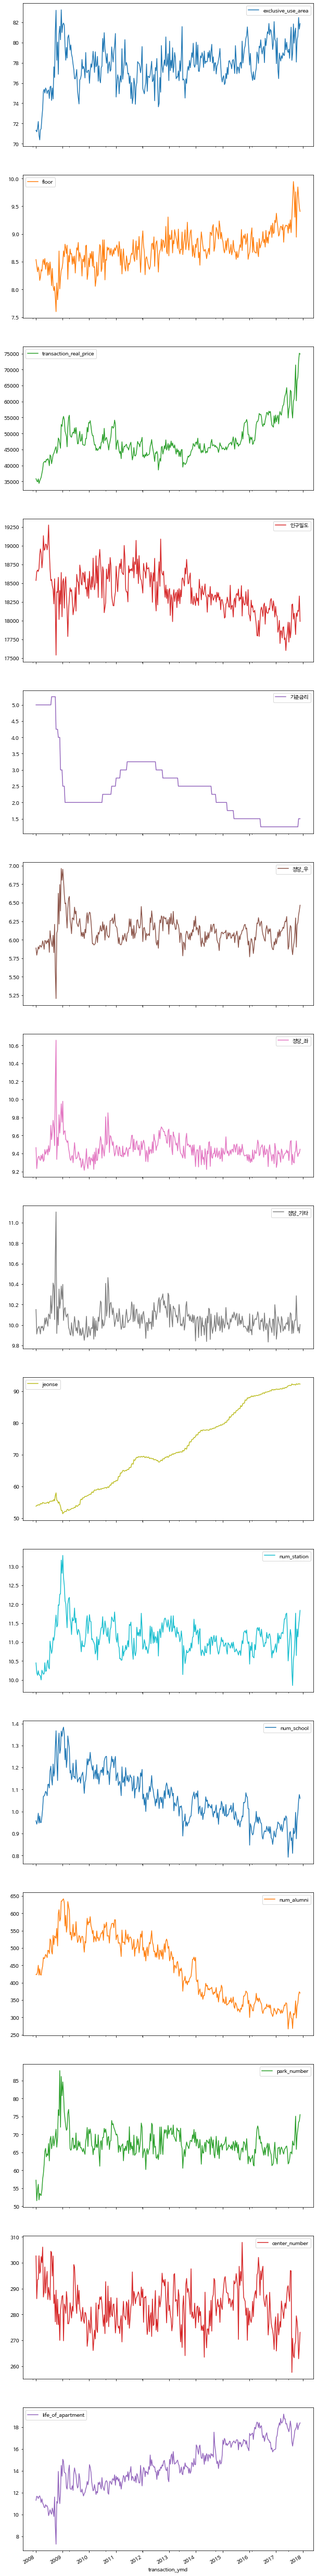

In [ ]:
time_train.plot(subplots=True, figsize = (10,100))
plt.show()

변수들마다 시간의 흐름에 따라 다양한 변화를 보여주네요!   


##### **Inst.**
실거래가와 전세 가격만 시간의 흐름에 따라 확인해볼까요?
1. time_train[['transaction_real_price', 'jeonse']] transaction_real_price와 jeonse 두 개의 컬럼으로 이루어진 새로운 데이터프레임에 대해서, 
2. .plot()으로 각 컬럼별로 subplot을 생성(subplots=True)할게요. 이때, figsize는 전체 subplot의 크기를 (10,16)로 지정해요!
3. plt.show()로 시각화된 그래프를 출력하면 됩니다.

##### **Hint.**
Pandas의 DataFrame 객체의 plot() 메소드를 사용하여, 서브플롯(subplots)으로 구성된 그래프를 출력할 때, 사용하는 파라미터는 다음과 같아요.    
- subplots: bool 타입. 기본값은 False. subplots=True로 설정하면, 서브플롯으로 구성된 그래프를 출력해요. 여러 개의 서브플롯이 한 화면에 출력됩니다!
- figsize: tuple 타입. 그래프의 크기(가로, 세로)를 설정해요. 단위는 인치입니다. (기본값: (6.4, 4.8))

plot()는 기본적으로 선 그래프(line plot)를 출력하며 다양한 파라미터를 지원하니, 아래 정보는 참고해주세요!    
- x: x축 값. 리스트, 배열 형태의 데이터 입력
- y: y축 값. 리스트, 배열 형태의 데이터 입력
- subplots: 서브플롯 여부
- figsize: 그래프 크기 입력 (가로, 세로)

##### **Solution**
plot 함수로 실거래가와 전세 가격에 대한 시계열 그래프를 그렸어요!

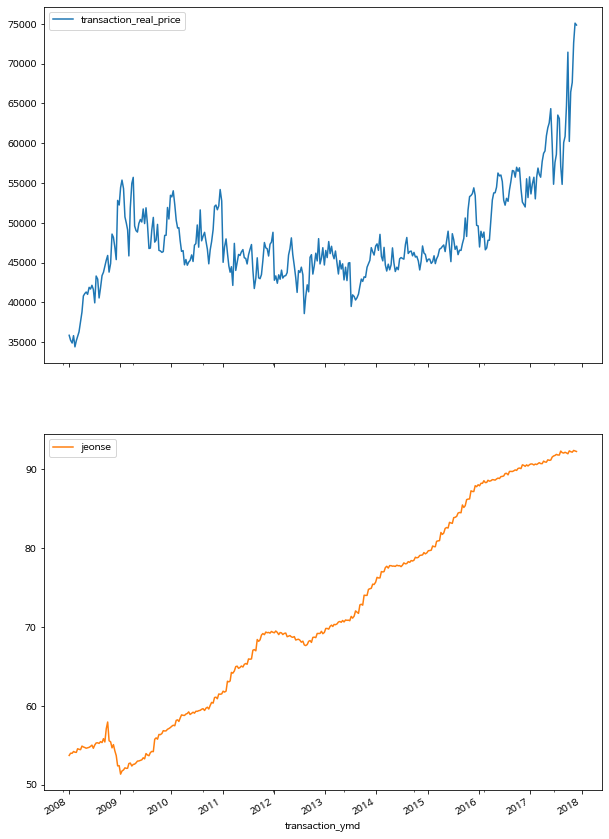

In [ ]:
time_train[['transaction_real_price', 'jeonse']].plot(subplots=True, figsize = (10,16))
plt.show()

중간에 하락도 있지만, 실거래가와 전세가격 모두 전체적으로 상승하고 있네요!    
이제, 본격적으로 시계열 모델을 적용해볼까요?

### **2. 시계열 기반 머신러닝/딥러닝 활용**

#### 2-1. 시계열 기반 머신러닝


##### 2-1-1. VAR(Vector Auto Regression)
VAR(Vector Auto Regression)은 시계열 데이터에서 다변량 자료를 분석하는 방법 중 하나로,     
자기회귀 모형인 AR(Auto Regression) 모형을 확장한 모형입니다!    
VAR 모형은 여러 개의 시계열 데이터가 시간적으로 상호의존적인 관계를 가지고 있다는 가정하에,    
다음 시간에 각 시계열이 어떻게 변화할지를 예측해요.    
이를 위해 VAR 모형은 각 변수를 과거 시점의 다른 변수들과 함께 회귀 모형으로 모델링한답니다.    

다시말하면, VAR 모델은 예측할 변수의 과거 값뿐만 아니라 예측할 변수와 의존성이 있는 변수까지 고려하여 선형 함수로 나타내는 확률적 과정을 보여줘요.

예를 들어, 실거래가와 기준금리 사이의 관계를 설명하는 이변량 분석을 아래 수식으로 확인할 수 있어요,

$$ 실거래가(t) = c1 + w11* 실거래가(t-1) + w12*기준금리(t-1) + e1(t-1) $$
$$ 기준금리(t) = c2 + w21* 실거래가(t-1) + w22*기준금리(t-1) + e2(t-1) $$

c1과 c2는 상수를 w11~w22는 계수, e1와 e2는 오차항을 의미해요.

수식이 이해되지 않으셔도 괜찮아요.   
실습으로 같이 확인해보시죠!

먼저, 필요한 모듈을 불러옵니다.     

statsmodels은 사용자가 데이터를 탐색하고 통계적 모델을 추정하며 통계적 테스트를 수행할 수 있게 도와주는 API로, 통계 및 시계열 모델인 VAR과 adfuller를 같이 불러오겠습니다.

In [ ]:
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

데이터가 정상성을 가진다는 의미는 데이터의 평균과 분산이 안정되어 있어 분석하기 쉽다는 의미입니다.     
일반적으로 평균이 일정하지 않으면 차분을 취하고, 분산이 일정하지 않으면 변환을 취합니다.

VAR을 수행하기 전에 변수가 모두 정상성을 가져야 하기때문에 변수의 상태를 확인해보겠습니다.


정상성을 확인할 컬럼을 가져옵니다.

In [ ]:
stationary_col = time_train.columns
stationary_col

Index(['exclusive_use_area', 'floor', 'transaction_real_price', '인구밀도', '기준금리',
       '정당_우', '정당_좌', '정당_기타', 'jeonse', 'num_station', 'num_school',
       'num_alumni', 'park_number', 'center_number', 'life_of_apartment'],
      dtype='object')

ADF(Advanced Dickey-Fuller test) 검정을 수행하여 정상성을 가지는지 확인해봅시다.    
여기서 ADF 검정은 시계열 데이터의 정상성을 검정하기 위한 검정 방법 중 하나입니다.   

ADF 검정은 statsmodels 라이브러리의 adfuller 함수를 통해 수행할 수 있어요.    
이 함수는 검정통계량과 p-value, 사용된 시차 등의 결과를 출력합니다!     
p-value가 유의수준보다 작다면 시계열 데이터가 정상성을 가진다고 판단할 수 있어요~ 

In [ ]:
# 정상성(Stationary)
adfuller_test_list = []

for c in stationary_col:
    adfuller_test = adfuller(time_train[c], autolag= "AIC")
    adfuller_test_list.append([c, adfuller_test[0], adfuller_test[1]])

df_stationary = pd.DataFrame(adfuller_test_list, columns=['columns_name', 'ADF test statistic', 'p-value']).sort_values(by='p-value', ascending=False)
df_stationary

,columns_name,ADF test statistic,p-value
2,transaction_real_price,1.107746,0.995282
8,jeonse,-0.164443,0.942629
14,life_of_apartment,-1.121617,0.706375
11,num_alumni,-1.125392,0.704840
1,floor,-1.977303,0.296613
10,num_school,-2.359731,0.153426
4,기준금리,-2.974409,0.037354
3,인구밀도,-3.124577,0.024787
6,정당_좌,-3.334153,0.013419
7,정당_기타,-3.572903,0.006301


p-value가 유의하지 않은 다음 6개 변수는 non-stationary 상태로 볼 수 있겠네요!

In [ ]:
not_stationary = list(df_stationary[df_stationary['p-value'] > 0.05]['columns_name'])
not_stationary

['transaction_real_price',
 'jeonse',
 'life_of_apartment',
 'num_alumni',
 'floor',
 'num_school']

non-stationary 상태의 변수들을 차분하여 stationary 상태로 변화되었는지 확인해봅시다

In [ ]:
# 차분(differencing)
time_train_diff = time_train[not_stationary].diff().dropna()

In [ ]:
diff_list = []

for c in not_stationary:
    adfuller_test = adfuller(time_train_diff[c], autolag= "AIC")
    diff_list.append([c, adfuller_test[0], adfuller_test[1]])

df_diff = pd.DataFrame(diff_list, columns=['columns_name', 'ADF test statistic', 'p-value']).sort_values(by='p-value', ascending=False)
df_diff

,columns_name,ADF test statistic,p-value
1,jeonse,-3.533928,7.157317e-03
0,transaction_real_price,-5.515957,1.924875e-06
2,life_of_apartment,-6.502847,1.150341e-08
3,num_alumni,-11.633346,2.235064e-21
4,floor,-14.956841,1.256421e-27
5,num_school,-18.336619,2.250327e-30


차분을 하니 모두 p-value가 유의미해졌네요!
전체 시계열 데이터에도 차분을 적용해봅시다.

In [ ]:
time_train_diff = time_train.copy()
time_train_diff[not_stationary] = time_train[not_stationary].diff()
time_train_diff = time_train_diff.dropna()
time_train_diff[not_stationary]

,transaction_real_price,jeonse,life_of_apartment,num_alumni,floor,num_school
transaction_ymd,,,,,,
2008-01-15,-624.553662,0.282082,0.367269,-0.032587,-0.105534,-0.015267
2008-01-26,-348.496815,-0.008754,-0.042540,7.285213,-0.115730,0.015102
2008-02-05,927.247682,0.225322,-0.165308,19.306753,0.088881,0.034688
2008-02-15,-1406.972614,-0.088395,0.184949,-28.301085,-0.064102,-0.045000
2008-02-25,788.041825,-0.023000,0.060266,18.110495,-0.179902,0.032148
...,...,...,...,...,...,...
2017-10-15,6208.011715,-0.101975,0.416738,34.045127,0.676981,0.085209
2017-10-26,1211.052893,-0.064149,-0.612327,9.763945,0.229335,0.034337
2017-11-05,4979.416088,0.220291,0.330440,22.513447,-0.202207,0.052390


대상 변수에 대해서 차분이 잘 적용되었으니, 이제 모델을 적용해볼까요?     
모델을 학습할 train 데이터셋과 test 데이터셋을 만듭니다.

In [ ]:
# 예측 데이터셋 분리
var_train = time_train_diff.iloc[:-20,:]
var_test = time_train_diff.iloc[-20:,:]

최적의 모델을 찾기 위한 기준으로 AIC(Akaike's Information Criterion)로 모델 선택해볼게요.     
AIC는 모델의 복잡성과 적합도를 모두 고려하여 모델의 성능을 평가하는데 사용되는 정보 기준입니다.   
1~10까지의 p 값으로 각각 모델을 학습하고 AIC 점수를 저장합니다.

In [ ]:
# VAR모델의 최적 순서 찾아보기
forecasting_model = VAR(var_train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


AIC 점수를 시각화했을때, 4에서 최적값을 가지네요!

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


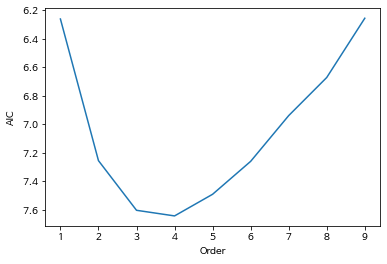

In [ ]:
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show() # 4에서 최적값

p를 4로 주고, 모델을 학습해봅시다.

In [ ]:
results = forecasting_model.fit(4)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 19, Feb, 2023
Time:                     11:13:09
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                    3.08037
Nobs:                     332.000    HQIC:                  -2.41826
Log likelihood:          -4790.32    FPE:                 0.00243545
AIC:                     -6.06571    Det(Omega_mle):     0.000264983
--------------------------------------------------------------------
Results for equation exclusive_use_area
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            14.239007        19.264195            0.739           0.460
L1.exclusive_use_area             0.373896         0.087376            4.279           0.000

학습한 모델로 test 데이터셋을 예측해봅시다~

In [ ]:
# 예측하기
laaged_values = var_train.values[-20:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=20), index = var_test.index, columns= stationary_col)
forecast[not_stationary] = time_train[not_stationary].iloc[-10-1] + forecast[not_stationary].cumsum()

각 변수에 대해 어떻게 예측되었는지 살펴볼까요?    
실제 값은 파란색, 예측 값은 주황색으로 표현되어 있습니다.

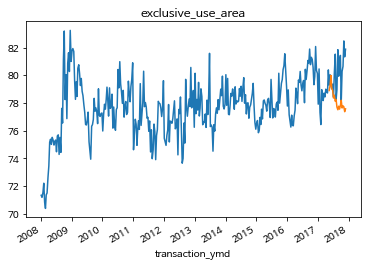

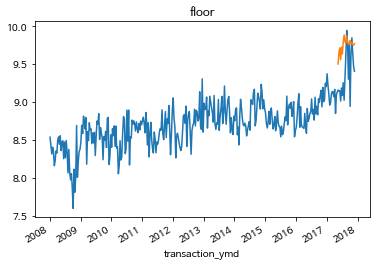

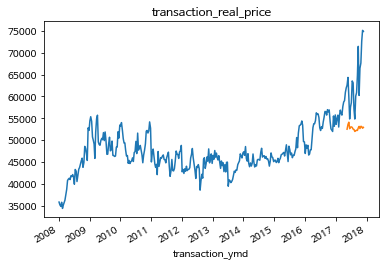

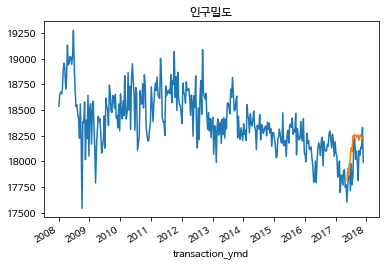

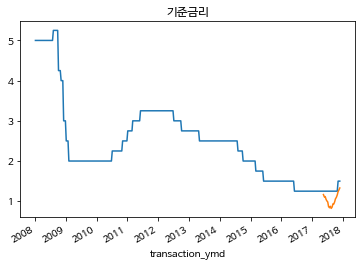

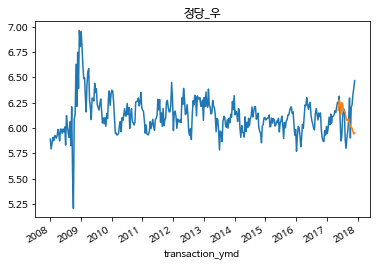

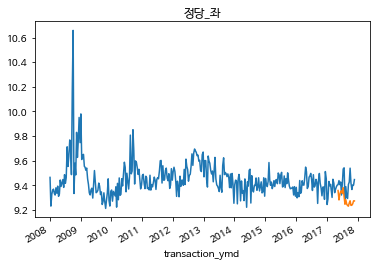

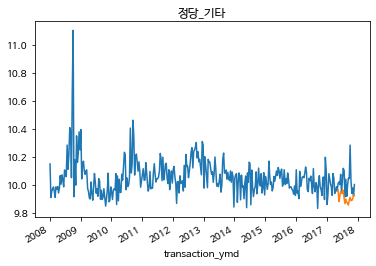

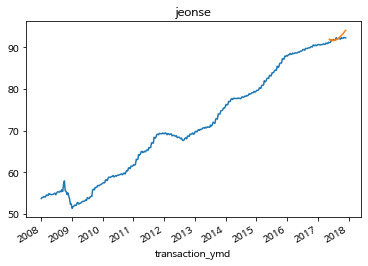

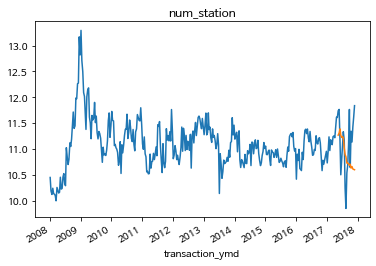

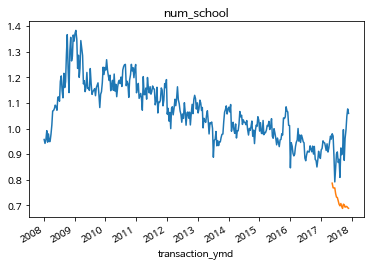

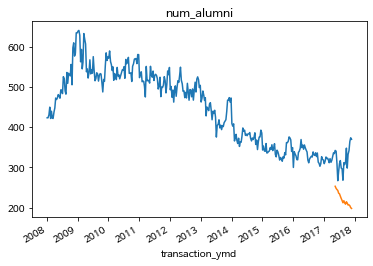

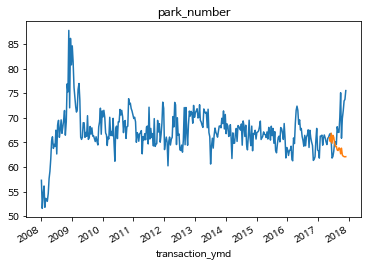

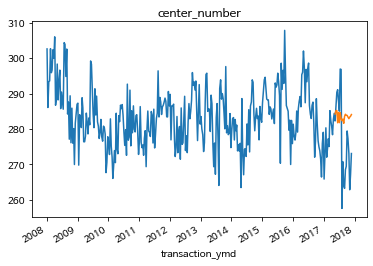

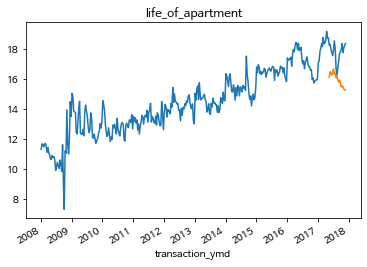

In [ ]:
feacure_col = forecast.columns

for c in feacure_col:
    time_train[c].plot()
    forecast[c].plot()
    plt.title(c)
    plt.show()

잘 예측한 변수도 있고, 그렇제 못한 변수도 있네요 🤔    
몇 개 뽑아서 살펴보는게 좋겠어요.

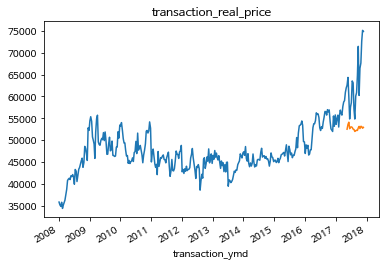

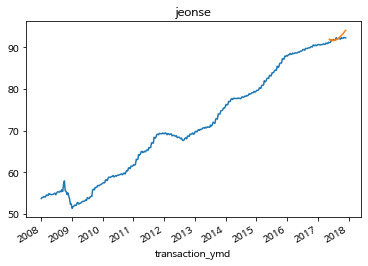

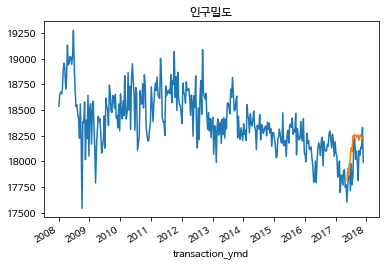

In [ ]:
for c in ['transaction_real_price', 'jeonse', '인구밀도', ]:
    time_train[c].plot()
    forecast[c].plot()
    plt.title(c)
    plt.show()

실거래가는 하락으로 예측했지만, 실제로 상승했네요 😞    
반면에 전세 가격 상승과 인구밀도 상승은 잘 예측되어 있네요!

##### 2-1-2. ARIMA(Autoregressice Integrated Moving Average)

ARIMA는 시계열 예측 모델 중 하나로, 현재 시점의 관측치와 이전 시점의 잔차(residuals) 사이의 관계를 모델링해요.   
ARIMA 모델은 Autoregression(AR), Integrated(I), Moving Average(MA)의 세 가지 요소로 구성된답니다.   

- Autoregression(AR): 자기 상관 관계를 모델링하는 것으로, 현재 시점의 관측치와 이전 시점의 관측치와의 관계를 모델링합니다.
- Integrated(I): 차분(difference)을 모델링하는 것으로, 시계열이 안정적이지 않은 경우 차분을 통해 안정적인 시계열로 변환하여 모델링합니다.
- Moving Average(MA): 이전 시점의 잔차와 현재 시점의 관측치와의 관계를 모델링하는 것으로, 잔차가 일정한 구간에서 어떤 패턴을 가지는지 모델링합니다.

ARIMA는 이러한 세 가지 요소를 이용하여 시계열 데이터를 모델링하며, 이때 각 요소의 차수(degree)를 지정해야 해요.    
ARIMA(p, d, q)에서 p는 AR의 차수, d는 차분의 차수, q는 MA의 차수를 나타냅니다!   

ARIMA 모델은 파라미터 선택, 모델 학습, 예측 등의 과정을 거쳐요.    
예측 결과는 실제 관측치와 비교하여 모델의 성능을 평가할 수 있어요.

statsmodel 모듈로 ARIMA 분석을 수행해볼까요?

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# 예측 데이터셋 분리
sx_train = time_train.iloc[:-20,:]
sx_test = time_train.iloc[-20:,:]



##### **Inst.**
SARIMAX 모듈로 ARIMA 분석을 수행해볼까요?
1. sm.tsa.statespace.SARIMAX를 사용하여 SARIMAX 모델 객체인 mdl을 생성하고요, 
2. endog 파라미터에는 종속 변수를 설정합니다!    
이 경우 sx_train 데이터프레임의 거래일자에 해당하는 'transaction_real_price' 컬럼을 넣으면 되겠죠?   
3. exog 파라미터에는 독립 변수를 설정해요.     
이 경우 sx_train 데이터프레임에서 'transaction_real_price' 컬럼을 제외한 나머지 컬럼을 독립 변수로 설정해요!
4. order 파라미터에는 ARIMA 모델의 차수를 설정할 수 있어요.     
이 경우 (1, 2, 1)로 설정하여 AR(1), 차분(D=2), MA(1) 모델을 생성해요.
5. 생성된 모델 객체 mdl에 fit 함수를 적용하여 모델을 학습시키고, 
6. 학습 결과를 res 변수에 저장해봐요!

##### **Hint.**
ARIMA 모델과 유사하지만, SARIMAX 모델은 계절성 요인(seasonality)을 반영할 수 있으며 외부의 영향을 받는 변수(exogenous variables)를 모델링할 수도 있어요.   

주요 파라미터은 다음과 같아요.
- endog : 종속 변수(Y)를 나타내는 데이터
- exog : 독립 변수(X)를 나타내는 데이터
- order : ARIMA의 파라미터를 나타내는 tuple(p,d,q)로써, p는 AR(자기회귀)의 차수, d는 차분(Differencing)의 차수, q는 MA(이동평균)의 차수를 나타냅니다.
    1. p: AR이 몇번째 과거까지를 바라보는지
    2. d: 차분(Defference)
    3. q: MA가 몇 번째 과거까지를 바라보는지를 나타낸다고 보시면 됩니다!


다변량 분석을 수행하기 때문에, exog 파라미터를 사용하여 모델에 외생변수를 꼭 추가해주세요!

##### **Solution**
SARIMAX 모델 객체를 생성하고, endog와 exog 데이터를 입력받아 mdl 모델을 생성해요.    
mdl 모델에 대해 fit() 함수를 적용하여 모델을 학습시키면 됩니다!

In [ ]:
mdl = sm.tsa.statespace.SARIMAX(endog=sx_train['transaction_real_price'], 
                                exog=sx_train.drop('transaction_real_price', axis=1), 
                                order=(1, 2, 1))
res = mdl.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     transaction_real_price   No. Observations:                  337
Model:                   SARIMAX(1, 2, 1)   Log Likelihood               -2747.228
Date:                    Tue, 21 Feb 2023   AIC                           5528.456
Time:                            05:11:58   BIC                           5593.296
Sample:                                 0   HQIC                          5554.306
                                    - 337                                         
Covariance Type:                      opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
exclusive_use_area   631.0760     44.002     14.342      0.000     544.834     717.318
floor                 89.8584    218.887      0.411      0.681    -339.153     518.869
인구밀도                  -1.7028      0.358     -4.757      0.000      -2.404      -1.001
기준금리                -426.3219    566.891     -0.752      0.452   -1537.409     684.765
정당_우                3420.8438   1274.281      2.685      0.007     923.298    5918.389
정당_좌               -2197.6847   1879.582     -1.169      0.242   -5881.597    1486.227
정당_기타               2064.6473   1597.569      1.292      0.196   -1066.531    5195.826
jeonse              -264.9916    119.633     -2.215      0.027    -499.469     -30.514
num_station          793.0177    421.161      1.883      0.060     -32.443    1618.478
num_school          3905.8207   4713.851      0.829      0.407   -5333.158    1.31e+04
num_alumni            19.8822      9.554      2.081      0.037       1.158      38.607
park_number          -40.3695     36.131     -1.117      0.264    -111.185      30.446
center_number         -8.2176     12.711     -0.647      0.518     -33.130      16.695
life_of_apartment    326.9661    102.571      3.188      0.001     125.931     528.001
ar.L1                 -0.1891      0.052     -3.631      0.000      -0.291      -0.087
ma.L1                 -0.9949      0.021    -47.377      0.000      -1.036      -0.954
sigma2              7.911e+05   6.76e+04     11.707      0.000    6.59e+05    9.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 6.68
Prob(Q):                              0.57   Prob(JB):                         0.04
Heteroskedasticity (H):               0.65   Skew:                            -0.18
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

전용면적, 인구밀도, 정당_우, 전세 가격, 졸업자수, 아파트 연수의 p-value( P>|z| )가 0.05이하로 유의미한 것으로 나타나네요!

마지막으로, 미래 값을 어떻게 예측했는지 살펴볼까요?    
학습한 ARIMA 모델로 test 데이터를 예측해봅시다.    
get_forecast()로 ARIMA 모델의 값을 예측할 수 있습니다.

In [ ]:
pred = []

for i in range(len(sx_test)):
    pred.append(res.get_forecast(step=20, exog=sx_test[i:i+1].drop('transaction_real_price', axis=1)).predicted_mean)

y_pred = sx_test.copy()
y_pred['transaction_real_price'] = pred
y_pred['transaction_real_price'] = y_pred['transaction_real_price'].apply(lambda x: float(str(x).split()[1]))

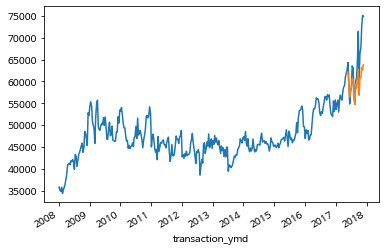

In [ ]:
time_train["transaction_real_price"].plot()
y_pred["transaction_real_price"].plot()
plt.show()

급격하게 가격이 상승한 부분을 제외하고는 얼추 비슷하네요!

#### 2-2. 시계열 기반 딥러닝


대표적인 시계열 딥러닝 기법인 LSTM을 활용해봅시다!   

LSTM (Long Short Term Memory)는 기존의 RNN이 출력과 먼 위치에 있는 정보를 기억할 수 없다는 단점을 보완하여 장/단기 기억을 가능하게 설계한 신경망의 구조를 말합니다. 주로 시계열 처리나, 자연어 처리에 사용되는 알고리즘으로 인지하고 계시면 좋을 것 같아요 😀

LSTM 시계열의 경우, [keras 공식문서 - 시계열 예제](https://keras.io/examples/timeseries/timeseries_weather_forecasting/)로도 확인할 수 있으니, 참고해주세요!    

각 단계에서 필요한 라이브러리를 불러옵니다.

In [ ]:
# 데이터 전처리 관련 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn import utils

# 딥러닝 모델 관련 라이브러리
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Model

# 딥러닝 학습 관련 라이브러리
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

학습을 위한 데이터셋을 분리합니다.  
  
모델의 학습을 위해 사용할 train 데이터 70%와,     
모델의 파라미터 업데이트를 위해 사용할 validation 데이터 20%,      
모델의 평가를 위해 사용할 test 데이터 10%를 아래와 같이 분리할 수 있습니다. 

In [ ]:
# 예측 데이터셋 분리
lstm_train = time_train.iloc[:-round(len(time_train)*0.3),:]
lstm_val = time_train.iloc[-round(len(time_train)*0.3):-round(len(time_train)*0.1),:]
lstm_test = time_train.iloc[-round(len(time_train)*0.1):,:]

Standard Scaler를 사용하여 실거래가 데이터를 학습에 용이하도록 변환합니다.

In [ ]:
transformer = StandardScaler()
lstm_train['transaction_real_price'] = transformer.fit_transform(lstm_train['transaction_real_price'].values.reshape(-1, 1))
lstm_val['transaction_real_price'] = transformer.fit_transform(lstm_val['transaction_real_price'].values.reshape(-1, 1))
lstm_test['transaction_real_price'] = transformer.transform(lstm_test['transaction_real_price'].values.reshape(-1, 1))

<ipython-input-151-b3c5d066571a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_train['transaction_real_price'] = transformer.fit_transform(lstm_train['transaction_real_price'].values.reshape(-1, 1))
<ipython-input-151-b3c5d066571a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_val['transaction_real_price'] = transformer.fit_transform(lstm_val['transaction_real_price'].values.reshape(-1, 1))
<ipython-input-151-b3c5d066571a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

독립변수를 lstm_col로 선언합니다.

In [ ]:
lstm_col = lstm_train.columns
lstm_col = lstm_col.drop('transaction_real_price')

7개의 샘플씩 시간 단위로 학습 가능하도록 train, validation, test 데이터셋을 구성해줍시다.

In [ ]:
sequence_length = 7
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(lstm_train) - window_length + 1):
    window = lstm_train[i:i + window_length]
    x_train.append(window[lstm_col])
    y_train.append(window['transaction_real_price'])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = []
y_val = []
for i in range(0, len(lstm_val) - window_length + 1):
    window = lstm_val[i:i + window_length]
    x_val.append(window[lstm_col])
    y_val.append(window['transaction_real_price'])
x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = []
y_test = []
for i in range(0, len(lstm_test) - window_length + 1):
    window = lstm_test[i:i + window_length]
    x_test.append(window[lstm_col])
    y_test.append(window['transaction_real_price'])
x_test = np.array(x_test)
y_test = np.array(y_test)

LSTM 모델을 선언합니다.
1. input Layer
2. hidden Layer: LSTM 모델
3. output Layer    

를 구성하고, 모델을 확인해봅시다.

In [ ]:
input = Input(shape=(sequence_length+1, len(x_train[0][0])))
lstm_out = LSTM(32)(input)
output= Dense(8)(lstm_out)

model = Model(inputs=input, outputs=output)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.1))
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8, 14)]           0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                6016      
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
Total params: 6,280
Trainable params: 6,280
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


모델 학습을 시작합시다!

In [ ]:
model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val)) 

Epoch 1/100
8/8 [==============================] - 3s 72ms/step - loss: 1.0658 - val_loss: 0.9943
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9805 - val_loss: 0.9961
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.9688 - val_loss: 0.9285
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.9426 - val_loss: 0.9463
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9362 - val_loss: 0.9529
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9360 - val_loss: 0.9401
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9545 - val_loss: 1.0248
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 1.0447 - val_loss: 1.0243
Epoch 9/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9544 - val_loss: 0.9393
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9533 - val_loss: 0.9447
Epoch 11/100
8/8 [========

학습한 모델로 test 데이터를 예측하고, 시각화해봅시다.

In [ ]:
y_predict = model.predict(x_test)
y_predict_viz = np.array(y_predict).flatten().tolist()
y_test_viz = np.array(y_test).flatten().tolist()

1/1 [==============================] - 0s 406ms/step


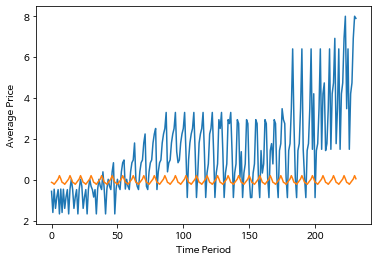

In [ ]:
plt.plot(y_test_viz)
plt.plot(y_predict_viz)
plt.xlabel('Time Period')
plt.ylabel('Average Price')
plt.show()

실제 값과 비교했을 때, 차이가 많네요.. 😢 여러가지 부가적인 처리가 필요해보입니다!

### **3. 최적 모델 선택 및 비교**

지금까지 시계열 모델링으로 거래일자에 따라 어떤 특징을 가지고 있는지 확인했습니다.   
이제 본격적으로 데이터 모델링을 시작해볼까요?

#### 3-1. 학습 모델 튜닝
지난 스테이지 **Stage 4.  EDA 기반 시각화 및 가공 - <font color="blue">WHERE</font>  어디서 아파트 가격이 잘 나타날까?** 에서 Light GBM이 높은 성능을 가진 것으로 나타났습니다!   
최적 Light GBM을 구할 수 있도록 학습해봅시다 😎    
모델 최적화를 위해 하이퍼파라미터 튜닝에 사용하는 Automl 라이브러리인 Qptuna를 사용하겠습니다.

Optuna 라이브러리를 먼저 설치해줍니다.


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


optuna와 함께 Light GBM, 성능평가, 도구 라이브러리를 임포트합니다.

In [ ]:
# AutoML 라이브러리
import optuna

# 머신러닝 모델 학습 관련 라이브러리
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

# RSME 성능평가 계산을 위한 라이브러리
from sklearn.metrics import mean_squared_error

# 프로그램 진행상황을 그림으로 볼 수 있게 해주는 파이썬 라이브러리
from tqdm import tqdm
from sklearn.model_selection import train_test_split

데이터를 train, validation, test 데이터셋으로 분리할게요~

In [ ]:
train = train.drop(['transaction_ymd'], axis=1)

In [ ]:
cut = int(len(train)*0.9)
h_train = train[:cut]
h_test = train[cut:]
h_test_X = h_test.drop('transaction_real_price', axis=1)
h_test_y = h_test['transaction_real_price']

Stage 4에서 적용했던 데이터전처리 기법도 동일하게 적용해볼까요?

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

rbs = RobustScaler()
rbs.fit(h_train[['exclusive_use_area', '인구밀도']])

h_train[['exclusive_use_area', '인구밀도']] = rbs.transform(h_train[['exclusive_use_area', '인구밀도']])
h_test_X[['exclusive_use_area', '인구밀도']] = rbs.transform(h_test_X[['exclusive_use_area', '인구밀도']])

mms_col = train.columns
mms_col = mms_col.drop(['transaction_real_price', 'life_of_apartment', 'floor'])
mms_col

mms = MinMaxScaler()
mms.fit(h_train[mms_col])
h_train[mms_col] = mms.transform(h_train[mms_col])
h_test_X[mms_col] = mms.transform(h_test_X[mms_col])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
h_train_X, h_valid_X, h_train_y, h_valid_y = train_test_split(h_train.drop('transaction_real_price', axis=1), h_train['transaction_real_price'], test_size=0.2, random_state=42)

In [ ]:
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape, h_test_X.shape, h_test_y.shape)

(549065, 14) (549065,) (137267, 14) (137267,) (76260, 14) (76260,)


train, validation, test 데이터셋의 크기가 적절하게 구성된 것을 확인할 수 있네요!

프로젝트의 평가 기준인 RMSE를 sklearn 라이브러리리의 mean_squared_error()로 함수를 선언했어요 😀

In [ ]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

light GBM 을 param으로 지정한 하이퍼 파라미터에 따라 튜닝을 진행해볼까요?    
시간상 optimize()의 n_trials=10으로 설정했는데요,   
더 많은 튜닝을 수행하고 싶으시면, 시행 횟수인 n_trials을 늘리시면 됩니다!

In [ ]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):

    param = {
        'objective': 'regression', # 회귀
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(h_valid_y, lgb_model.predict(h_valid_X))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2023-02-21 15:24:49,584] A new study created in memory with name: no-name-91855997-d466-4f36-a00c-1e58df273f58
[I 2023-02-21 15:26:27,021] Trial 0 finished with value: 24966.0806580386 and parameters: {'max_depth': 13, 'learning_rate': 0.0002075292860745214, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6991042073815543}. Best is trial 0 with value: 24966.0806580386.
[I 2023-02-21 15:27:54,270] Trial 1 finished with value: 13045.295504110756 and parameters: {'max_depth': 5, 'learning_rate': 0.0019806366669675923, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4530038885044062}. Best is trial 1 with value: 13045.295504110756.
[I 2023-02-21 15:27:59,442] Trial 2 finished with value: 18717.575204261728 and parameters: {'max_depth': 11, 'learning_rate': 0.009533933928015903, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8875725769912681}. Best is trial 1 with value: 13045.295504110756.
[I 2023-02-21 15:28:36,340] Trial 3 finished with value:

#### 2-2. 최적 모델 선택
best_trial로 학습 최적모델을 불러와볼게요!
best_trial.params로 최적모델의 하이퍼 파라미터를 불러올 수 있습니다.

In [ ]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 10242.236761169435,
params {'max_depth': 14, 'learning_rate': 0.009990560009908885, 'n_estimators': 2915, 'min_child_samples': 23, 'subsample': 0.586428406286942}


In [ ]:
trial_params = {'max_depth': 14, 'learning_rate': 0.009990560009908885, 'n_estimators': 2915, 'min_child_samples': 23, 'subsample': 0.586428406286942}

RMSE 점수는 10242 였고, 하이퍼파라미터는 깊이 14, 학습률 0.01 등으로 나타나네요!

최적 하이퍼파라미터로 최종 모델을 다시 학습시켜봅시다~     
LGBMRegressor()으로 모델을 선언하고, fit() 함수로 학습을 진행할 수 있어요!   

In [ ]:
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0, early_stopping_rounds=25)

LGBMRegressor(learning_rate=0.009990560009908885, max_depth=14,
              min_child_samples=23, n_estimators=2915,
              subsample=0.586428406286942)

predict() 함수로 테스트 데이터로 예측을 수행하고, 성능평가를 해볼까요?

In [ ]:
final_lgb_pred = final_lgb_model.predict(h_test_X)
RMSE(h_test_y, final_lgb_pred)

18706.436808184528

RMSE 점수가 18706로 아주 좋아졌네요!

feature_importances_로 모델에서 사용된 변수의 중요도를 파악할 수 있습니다.   
barh()를 사용하여 가로 막대그래프로 시각화해볼까요?

<BarContainer object of 14 artists>

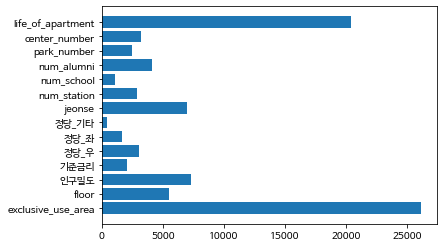

In [ ]:
plt.barh(h_train_X.columns, final_lgb_model.feature_importances_)

학습한 모델이 날아가버리면 안되겠죠?   
joblib 라이브러리로 학습한 모델을 저장할 수 있습니다!

모델을 저장하기 위해 joblib 라이브러리를 임포트해봅시다.

In [ ]:
import joblib

dump() 함수로 모델과 저장 경로를 지정할 수 있습니다.

In [ ]:
# 모델 저장
joblib.dump(final_lgb_model, '/content/drive/MyDrive/데이크루4기_먼스크루/model/lgb_final_model.pkl')

['/content/drive/MyDrive/데이크루4기_먼스크루/model/lgb_final_model.pkl']

load() 함수로 모델을 다시 불러와서 예측할 수 있답니다 😋

In [ ]:
# 모델 불러오기
load_model = joblib.load('/content/drive/MyDrive/데이크루4기_먼스크루/model/lgb_final_model.pkl')

In [ ]:
final_lgb_pred = load_model.predict(h_test_X)
RMSE(h_test_y, final_lgb_pred)

18706.436808184528

불러온 모델로 다시 학습해도 같은 결과가 나오네요!


아파트 실거래가를 예측하는 최적 모델을 얻으셨군요! 휼륭합니다~
<img src='http://drive.google.com/uc?export=view&id=1a0_ofQLehKLINRG8LM5jztkCwkjStz07' /><br>
Stage 5까지 오시느라 고생 많으셨습니다! 마지막 스테이지에서 다시 만나요 ✋